In [1]:
%reload_ext dotenv
%dotenv

In [ ]:
from PIL import Image

#### Load some images to work with

In [ ]:
garments = {
    "jeans": {
        "image": Image.open("../../images/garments/bottoms/jeans.webp"),
        "category": "lower_body",
        "description": "jeans"
    },
    "tshirt": {
        "image": Image.open("../../images/garments/tops/tshirt.webp"),
        "category": "upper_body",
        "description": "tshirt"
    }
}

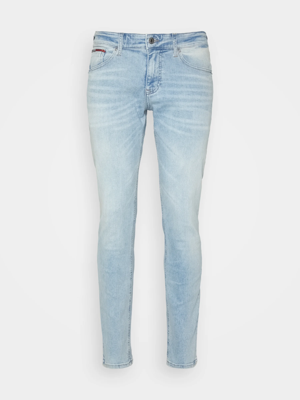

In [48]:
garments["jeans"]["image"].resize((300, 400))

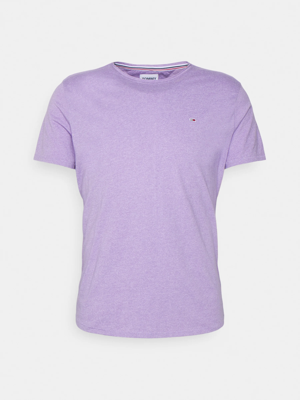

In [53]:
garments["tshirt"]["image"].resize((300, 400))

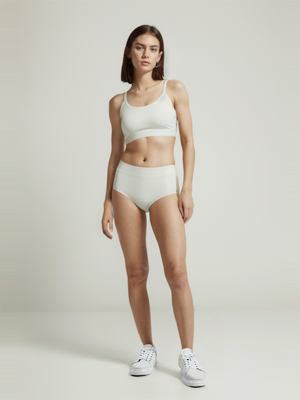

In [27]:
human_image = Image.open("../../images/humans/model.jpg")
human_image.resize((300, 400))

#### Use the VTON model to put a garment on a human

In [54]:
import io
import replicate
import requests


def image_to_binary(image: Image.Image) -> io.BytesIO:
    stream = io.BytesIO()
    image.save(stream, format="JPEG")
    stream.seek(0)
    return stream


def put_garment_on_human(garment, human_image) -> Image.Image:
    input = {
        "garm_img": image_to_binary(garment["image"]),
        "human_img": image_to_binary(human_image),
        "garment_des": garment["description"],
        "category": garment["category"],
    }

    result_url: str = replicate.run(
        "cuuupid/idm-vton:c871bb9b046607b680449ecbae55fd8c6d945e0a1948644bf2361b3d021d3ff4",
        input=input,
    )  # type: ignore

    return Image.open(requests.get(result_url, stream=True).raw)

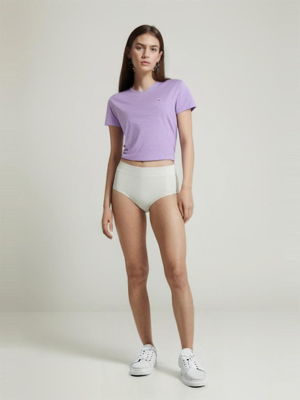

In [ ]:
top_on_human = put_garment_on_human(garments["tshirt"], human_image)
top_on_human.resize((300, 400))

#### Find out where the garment was drawn (image segmentation)

In [88]:
from google import genai
from google.genai.types import GenerateContentConfig, ThinkingConfig
import re
from pydantic import BaseModel, TypeAdapter


class ObjectDetection(BaseModel):
    box_2d: list[int]
    mask: str


def parse_objects(json_text: str) -> list[ObjectDetection]:
    text = re.sub(r"^```json", "", json_text)
    text = re.sub(r"```$", "", text)
    objects = TypeAdapter(list[ObjectDetection]).validate_json(text)
    return objects


def detect_garment(garment, garment_on_human: Image.Image) -> ObjectDetection:
    client = genai.Client()
    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[
            garment_on_human,
            f"""
            Give the segmentation mask for the {garment["description"]}.
            Output a JSON list of segmentation masks where each entry contains the 2D bounding box in "box_2d" and the mask in "mask".
            """.strip(),
        ],
        config=GenerateContentConfig(
            # Google says it works better without thinking
            thinking_config=ThinkingConfig(thinking_budget=0),
        ),
    )

    assert response.text is not None
    print("Raw response:", response.text)

    assert response.usage_metadata is not None
    print("Input tokens:", response.usage_metadata.prompt_token_count)
    print("Thinking tokens:", response.usage_metadata.thoughts_token_count)
    print("Output tokens:", response.usage_metadata.candidates_token_count)

    objects = parse_objects(response.text)
    return objects[0]  # assume there is only one object: our garment

Raw response: ```json
[
  {"box_2d": [197, 347, 404, 650], "mask": "", "label": "the tshirt"}
]
```
Input tokens: 300
Thinking tokens: None
Output tokens: 65

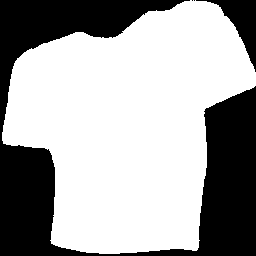

ObjectDetection(box_2d=[197, 347, 404, 650], mask='')
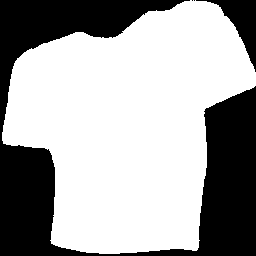

In [ ]:
detection = detect_garment(garments["tshirt"], top_on_human)
detection

#### Visualize the image segmentation result as a mask

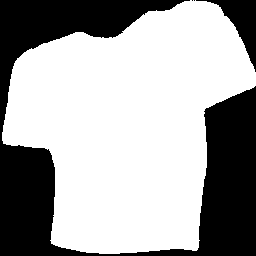

In [99]:
import base64
from io import BytesIO


def get_mask_image(detection: ObjectDetection):
    # Remove the data URL prefix if present
    mask_b64 = re.sub(r"^data:image/png;base64,", "", detection.mask)
    mask_bytes = base64.b64decode(mask_b64)
    return Image.open(BytesIO(mask_bytes)).convert("L")  # Grayscale


mask_image = get_mask_image(detection)
mask_image

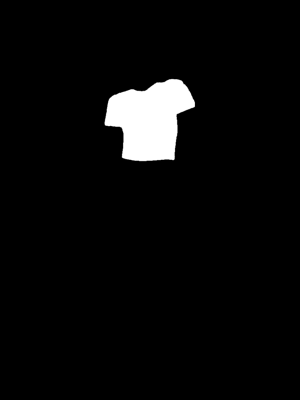

In [104]:
from PIL.Image import Resampling
import numpy as np


def resize_mask(
    mask_image: Image.Image, garment_on_human_image: Image.Image
) -> Image.Image:
    # Our data is [ymin, xmin, ymax, xmax] in 0-1000
    ymin, xmin, ymax, xmax = detection.box_2d
    w, h = garment_on_human_image.size

    # Normalize if any value > 1000 (as in JS)
    if any(v > 1000 for v in (ymin, xmin, ymax, xmax)):
        ymin = (ymin / h) * 1000
        xmin = (xmin / w) * 1000
        ymax = (ymax / h) * 1000
        xmax = (xmax / w) * 1000

    # Convert to normalized [0,1] coordinates
    nYmin, nXmin, nYmax, nXmax = [v / 1000 for v in (ymin, xmin, ymax, xmax)]

    # Compute pixel coordinates
    left = int(round(nXmin * w))
    top = int(round(nYmin * h))
    right = int(round(nXmax * w))
    bottom = int(round(nYmax * h))

    box_width = max(1, right - left)
    box_height = max(1, bottom - top)

    # Resize the mask to fit the bounding box
    mask_box_resized = mask_image.resize(
        (box_width, box_height), resample=Resampling.BILINEAR
    )

    # Paste the resized mask into a full-size mask at the correct position
    mask_resized = Image.new("L", garment_on_human_image.size, 0)
    mask_resized.paste(mask_box_resized, (left, top))

    return mask_resized


mask_resized = resize_mask(mask_image, top_on_human)
mask_resized.resize((300, 400))

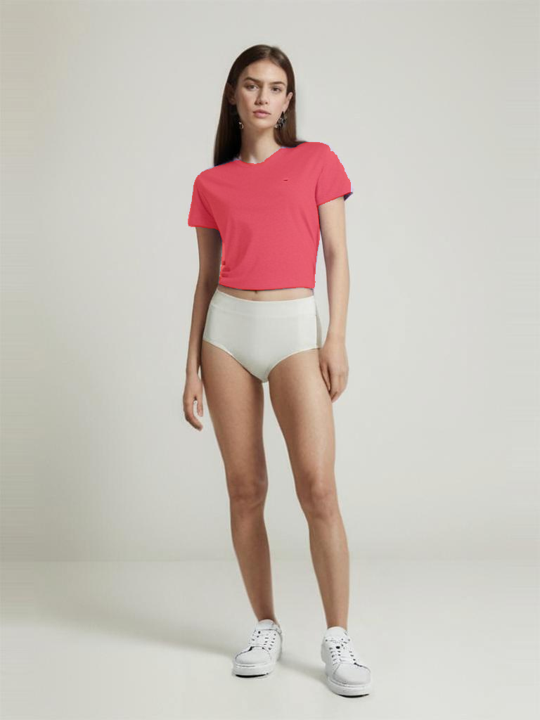

In [106]:
def overlay_mask(
    mask_resized: Image.Image, garment_on_human_image: Image.Image
) -> Image.Image:
    # Create a color overlay (e.g., red) with 50% opacity where mask is present
    overlay = Image.new("RGBA", garment_on_human_image.size, (255, 0, 0, 0))
    mask_np = np.array(mask_resized)
    alpha = (mask_np > 0) * 128  # 50% opacity where mask is present
    overlay_np = np.array(overlay)
    overlay_np[..., 3] = alpha
    overlay = Image.fromarray(overlay_np, mode="RGBA")

    # Composite overlay onto garment_on_human
    rgba = garment_on_human_image.convert("RGBA")
    return Image.alpha_composite(rgba, overlay)


overlay = overlay_mask(mask_resized, top_on_human)
overlay.resize((540, 720))

#### Let's do the same with a bottom garment

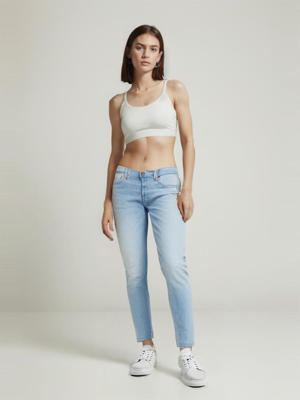

In [ ]:
bottom_on_human = put_garment_on_human(garments["jeans"], human_image)
bottom_on_human.resize((300, 400))

#### And combine the two!

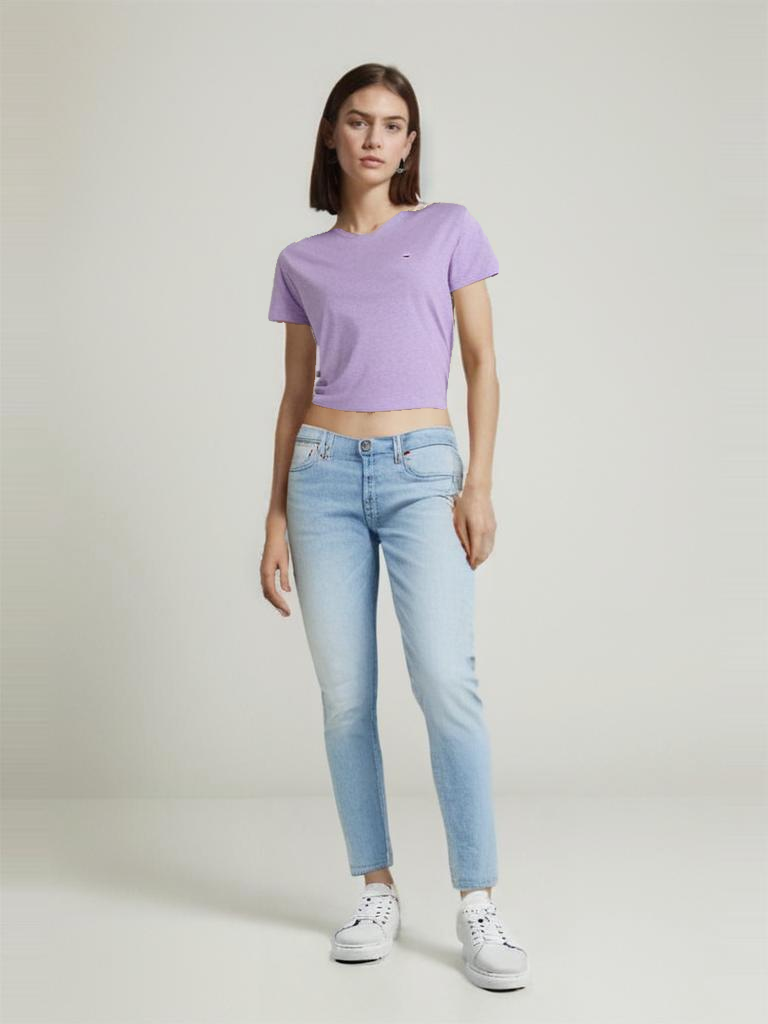

In [107]:
def combine_garments(
    human_image: Image.Image,
    top_im: Image.Image,
    bottom_im: Image.Image,
    top_mask_im: Image.Image,
):
    result = Image.new("RGB", human_image.size)
    result.paste(bottom_im, (0, 0))
    result.paste(top_im, (0, 0), top_mask_im.convert("L"))
    return result


final_image = combine_garments(human_image, top_on_human, bottom_on_human, mask_resized)
final_image